# Statistical modeling of sea level along the coast of the Netherlands using Generalized Additive Model (GAM)


__Note on the environment required to run the notebook:__

An installation of Python 3.9 with recent versions of the libraries (numpy, scipy, matplotlib, pandas, xarray, statsmodels, spectrum) should run this Notebook wihout modification.

__Note on running the notebook:__

The computation of the uncertainty range can be rather heavy so it is advised to reduce the bootstrap samples from 1000 to 100 to first make sure the code works and then increase it back to 1000.

In [217]:
# Import libraries

import numpy as np
from numpy.polynomial import Polynomial

from scipy.stats import norm, pearsonr
from scipy.signal import detrend
import scipy.fft as fft
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

import local_functions as loc

In [218]:
# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')


## Define fixed data

In [219]:
# Set paths
data_atmosphere_dir = './data_atmosphere'
data_tidegauges_dir = '/Users/iriskeizer/Documents/Wind effect/paper/code check/data'

# Method to constrain the BSpline smoothing. 
# The character is only used for figures.
# m1 for constrained by degrees of freedom
# m2 for constrained by penalisation weights
method = 'm2'

# Define window in years for rate computation, should be an even number
lag = 2

## Choose a region
The notebook was only tested for the Netherlands and Belgium but other regions can be defined here using the tide gauge ids used by the PSMSL data.

For the Netherlands the six main tide gauges with reliable data since 1890 are used (Vlissingen, Hoek van Holland, IJmuiden, Den Helder, Harlingen, Delfzijl).
For Belgium three tide gauges are used (Nieuwpoort, Oostende, Zeebrugge), unfortunately they only have data since 1967.

In [220]:
region = 'Vlissingen'

if region == 'Netherlands':
    tg_id = [20, 22, 23, 24, 25, 32]
elif region == 'Belgium':
    tg_id = [489, 413, 470]
elif region == 'Vlissingen':
    tg_id = [20]
elif region == 'Hoek van Holland':
    tg_id = [22]
elif region == 'Den Helder':
    tg_id = [23]
elif region == 'Delfzijl':
    tg_id = [24]
elif region == 'Harlingen':
    tg_id = [25]
elif region == 'IJmuiden':
    tg_id = [32]

## Read tide gauge data and compute the average

In [221]:
def tide_gauge_obs(tg_id=[20, 22, 23, 24, 25, 32], interp=False):
    '''Read a list of tide gauge data and compute the average. 
    Set interp to True for a linear interpollation of missing values.
    By default use the 6 tide gauges from the Zeespiegelmonitor.
    The unit of the output is cm.''' 
    
    tg_data_dir = f'{data_tidegauges_dir}/tide gauges/rlr_annual'
    names_col = ('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality')
    filelist_df = pd.read_csv(tg_data_dir + '/filelist.txt', sep=';', 
                              header=None, names=names_col)
    filelist_df = filelist_df.set_index('id')

    names_col2 = ('time', 'height', 'interpolated', 'flags')

    for i in range(len(tg_id)):
        tg_data = pd.read_csv(f'{tg_data_dir}/data/{tg_id[i]}.rlrdata', 
                              sep=';', header=None, names=names_col2)
        tg_data = tg_data.set_index('time')
        tg_data.height = tg_data.height.where(~np.isclose(tg_data.height,-99999))
        tg_data.height = tg_data.height - tg_data.height.mean()

        if i==0:
            tg_data_df = pd.DataFrame(data=dict(time=tg_data.index, 
                                                col_name=tg_data.height))
            tg_data_df = tg_data_df.set_index('time')
            tg_data_df.columns  = [str(tg_id[i])] 
        else:
            tg_data_df[str(tg_id[i])] = tg_data.height

    if interp:
        tg_data_df = tg_data_df.interpolate(method='slinear')
        
    tg_data_df['Average'] = tg_data_df.mean(axis=1)
    tg_data_df = tg_data_df * 0.1 # Convert from mm to cm
    
    return tg_data_df

In [222]:
tg_df = tide_gauge_obs(tg_id, interp=True)

if region in ['Netherlands', 'Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden']:
    tg_df = tg_df.loc[1890:] # Select years after 1890 as in the Zeespiegelmonitor
elif region == 'Belgium':
    tg_df = tg_df.loc[1967:] # Only from 1967 the 3 tide gauges have data

nt = len(tg_df.index)    

tg_df

,20,Average
time,,
1890,-13.450625,-13.450625
1891,-16.250625,-16.250625
1892,-16.150625,-16.150625
1893,-13.550625,-13.550625
1894,-8.650625,-8.650625
...,...,...
2017,16.349375,16.349375
2018,11.849375,11.849375
2019,16.849375,16.849375


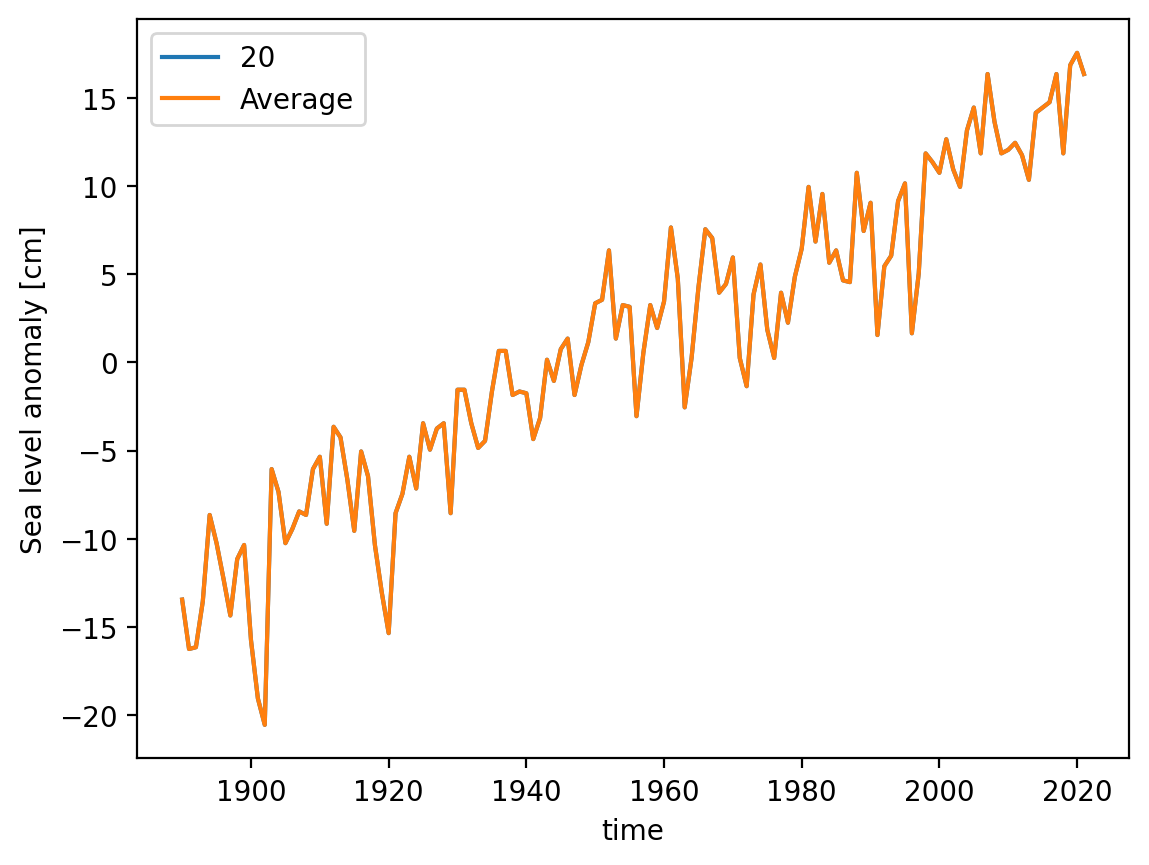

In [223]:
tg_df.plot()
plt.ylabel('Sea level anomaly [cm]');


Export data to output directory

In [224]:
tg_df.to_csv(f'./outputs/{region}/data_tide_gauges.csv')

## Compute wind impact on sea level

20CR wind pseudo-stress data are bias-corrected (relative to ERA5) by a componentwise linear scaling. The scaling is determined from the overlapping data (1950-2015) by matching means and variances.


In [225]:
def combine_linear_scaling(d20CR, dERA5, date_s, date_e):
    
    d20CR_cor = d20CR.copy()
    
    # Substract mean of 20CR over overlapping period
    d20CR_cor = d20CR - d20CR.loc[date_s:date_e].mean()
    
    # Scale using variance
    d20CR_cor = d20CR_cor*dERA5.loc[date_s:date_e].std()/d20CR_cor.loc[date_s:date_e].std()
    
    # Substract mean of ERA5 over overlapping period
    d20CR_cor = d20CR_cor + dERA5.loc[date_s:date_e].mean()
    
    combined_df = pd.concat([d20CR_cor.loc[:1949], dERA5.loc[1950:]])
    
    return combined_df

In [226]:
def read_wind_np(tgi):
    '''Read wind info for the two reanalysis files and combine them'''
    
    wind_info_20CR = pd.read_csv(f'{data_atmosphere_dir}/wind_data_20CR_tg{tgi}.csv')
    wind_info_20CR = wind_info_20CR.set_index('t')

    wind_info_ERA5 = pd.read_csv(f'{data_atmosphere_dir}/wind_data_ERA5_tg{tgi}.csv')
    wind_info_ERA5 = wind_info_ERA5.set_index('t')

    combined_df = combine_linear_scaling(wind_info_20CR[['u2','v2']], wind_info_ERA5[['u2','v2']], 1950, 2015)
    
    combined_df.index.rename('time', inplace=True)
    combined_df.rename(columns = {'u2' : f'u2_{tgi}', 'v2' : f'v2_{tgi}'}, inplace=True)
    
    return combined_df

In [227]:
for idx, tgi in enumerate(tg_id):
    
    if idx == 0:
        nearest_point_df = read_wind_np(tgi)
    else:
        nearest_point_df = nearest_point_df.join(read_wind_np(tgi), how='inner')
    
nearest_point_df['u2_mean'] = nearest_point_df.filter(regex='u2_').mean(axis=1)
nearest_point_df['v2_mean'] = nearest_point_df.filter(regex='v2_').mean(axis=1)

nearest_point_df

,u2_20,v2_20,u2_mean,v2_mean
time,,,,
1836,6.372421,1.366331,6.372421,1.366331
1837,1.710303,0.172284,1.710303,0.172284
1838,1.717848,-0.747332,1.717848,-0.747332
1839,2.448895,0.325138,2.448895,0.325138
1840,4.391965,0.016533,4.391965,0.016533
...,...,...,...,...
2018,1.602312,0.977441,1.602312,0.977441
2019,3.602311,2.800432,3.602311,2.800432
2020,5.776837,4.740365,5.776837,4.740365


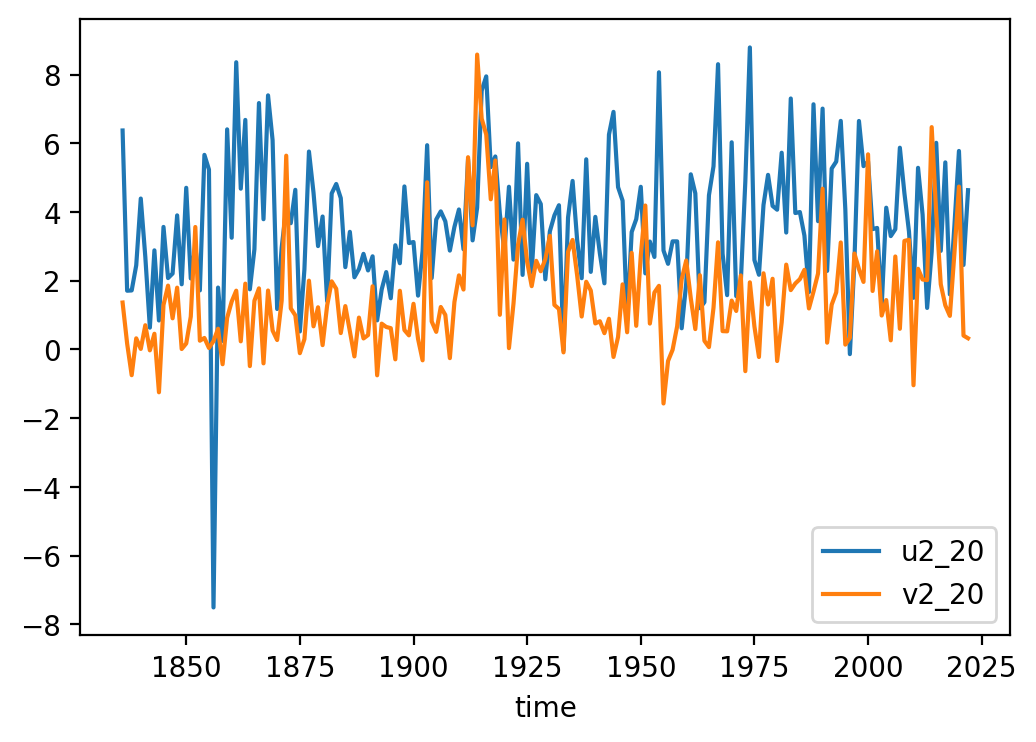

In [228]:
if len(tg_id) == 1:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    
    nearest_point_df[[f'u2_{tg_id[0]}',f'v2_{tg_id[0]}']].plot(ax=axes)
elif len(tg_id) == 3:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
    
    for idx, tgi in enumerate(tg_id):
        nearest_point_df[[f'u2_{tgi}',f'v2_{tgi}']].plot(ax=axes[int(idx/3), idx%3])
        
elif len(tg_id) == 6:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

    for idx, tgi in enumerate(tg_id):
        nearest_point_df[[f'u2_{tgi}',f'v2_{tgi}']].plot(ax=axes[int(idx/3), idx%3])
    


In [229]:
argm = nearest_point_df[f'u2_{tg_id[0]}'].argmin()
nearest_point_df[f'u2_{tg_id[0]}'].index[argm]

1856

Is the year 1856 an outlier? Can we trust data for this year?

Cross-correlation between the zonal and meridional wind contributions

In [230]:
pearsonr(nearest_point_df['u2_mean'],nearest_point_df['v2_mean'])

PearsonRResult(statistic=0.36387445366269294, pvalue=3.0695677114672895e-07)

The correlation between u2_mean and v2_mean would be almost impossible to obtain if those two time series were independent.

In [231]:
def normalize_ts(sr):
    
    sr = (sr-sr.mean())/sr.std()
    
    return sr

def read_pres_dangendorf(reanalysis):
    
    dang_pres = pd.read_csv(f'{data_atmosphere_dir}/dangendorf_{reanalysis}_wind_data.csv')
    dang_pres.set_index('time', inplace=True)
    dang_pres.rename(columns={'Negative corr region' : 'pressure_north', 
                              'Positive corr region' : 'pressure_south'}, inplace=True)

    dang_pres['pressure_diff'] = dang_pres['pressure_south'] - dang_pres['pressure_north']
    
    # Normalize the values before linear regression
    dang_pres['pressure_north'] = normalize_ts(dang_pres['pressure_north'])
    dang_pres['pressure_south'] = normalize_ts(dang_pres['pressure_south'])
    dang_pres['pressure_diff'] = normalize_ts(dang_pres['pressure_diff'])    
    
    return dang_pres

dang_pres_20CR = read_pres_dangendorf('20cr')
dang_pres_ERA5 = read_pres_dangendorf('era5')

dang_df = combine_linear_scaling(dang_pres_20CR, dang_pres_ERA5, 1950, 2015)

dang_df

,pressure_north,pressure_south,pressure_diff
time,,,
1836,0.463059,-0.863668,-0.670663
1837,2.306433,-1.262575,-2.117780
1838,2.573040,-2.564891,-2.830682
1839,2.951302,-2.058643,-2.889670
1840,1.143408,-1.474510,-1.392353
...,...,...,...
2018,1.358014,-0.676661,-1.234210
2019,-0.462461,0.152607,0.391477
2020,-1.777034,1.291718,1.765501


### Define the relation between wind and sea level

There are different ways to remove the wind effect on sea level. We choose here the 'NearestPoint' method that picks for each tide gauge the closest grid point from the reanalysis data and applies a multi-linear regression model between the square of the zonal and meridioan wind components and sea level. See the master thesis of Iris Keizer or the [zeespiegel monitor 2018](https://www.deltares.nl/app/uploads/2019/03/Zeespiegelmonitor-2018-final.pdf) for more details about this method.

#### Prepare a matrix of potential regressors

In [232]:
t = tg_df.index

reg_df = pd.DataFrame({'sea_level':tg_df['Average']})

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

reg_df = reg_df.join(nearest_point_df, how='inner')
reg_df = reg_df.join(dang_df, how='inner')
    
reg_df['one'] = np.ones(len(reg_df.index))

reg_df

,sea_level,nod1,nod2,u2_20,v2_20,u2_mean,v2_mean,pressure_north,pressure_south,pressure_diff,one
time,,,,,,,,,,,
1890,-13.450625,1.000000,0.000000,2.299962,0.420126,2.299962,0.420126,0.250395,-1.182070,-0.651169,1.0
1891,-16.250625,0.943562,0.331195,2.711113,1.839988,2.711113,1.839988,0.655738,-0.460017,-0.641725,1.0
1892,-16.150625,0.780620,0.625006,0.847923,-0.750950,0.847923,-0.750950,0.686439,-2.225395,-1.377455,1.0
1893,-13.550625,0.529565,0.848270,1.746675,0.751888,1.746675,0.751888,0.172267,-1.945935,-0.905755,1.0
1894,-8.650625,0.218735,0.975784,2.251831,0.655649,2.251831,0.655649,0.740861,-0.472324,-0.706076,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2017,16.349375,0.443818,-0.896117,5.444597,1.284119,5.444597,1.284119,-0.839329,1.455028,1.146817,1.0
2018,11.849375,0.715559,-0.698552,1.602312,0.977441,1.602312,0.977441,1.358014,-0.676661,-1.234210,1.0
2019,16.849375,0.906532,-0.422138,3.602311,2.800432,3.602311,2.800432,-0.462461,0.152607,0.391477,1.0


In [233]:
reg_df.filter(regex='v2_')

,v2_20,v2_mean
time,,
1890,0.420126,0.420126
1891,1.839988,1.839988
1892,-0.750950,-0.750950
1893,0.751888,0.751888
1894,0.655649,0.655649
...,...,...
2017,1.284119,1.284119
2018,0.977441,0.977441
2019,2.800432,2.800432


#### Define the list of regressors and regression formula for the different models

In [234]:
# No regressor

reg_list_nr = ['one']

regression_formula_nr = 'sea_level ~ '+' + '.join(reg_list_nr)

regression_formula_nr

'sea_level ~ one'

In [235]:
# Only lunar nodal tide

reg_list_nt = ['nod1', 'nod2']

regression_formula_nt = 'sea_level ~ '+' + '.join(reg_list_nt)

regression_formula_nt

'sea_level ~ nod1 + nod2'

In [236]:
# Nearest point average, including only zonal wind  'NearestPointAverage'

reg_list_na = ['nod1', 'nod2', 'u2_mean']

regression_formula_na = 'sea_level ~ '+' + '.join(reg_list_na)
    
regression_formula_na

'sea_level ~ nod1 + nod2 + u2_mean'

In [237]:
# Nearest point average, including zonal and meridional wind 'NearestPointAverage2'

reg_list_na_2 = ['nod1', 'nod2', 'u2_mean', 'v2_mean']


regression_formula_na_2 = 'sea_level ~ '+' + '.join(reg_list_na_2)
    
regression_formula_na_2

'sea_level ~ nod1 + nod2 + u2_mean + v2_mean'

In [238]:
# Pressure difference  'PressureDifference'

reg_list_pd = ['nod1', 'nod2', 'pressure_diff']

regression_formula_pd = 'sea_level ~ '+' + '.join(reg_list_pd)
    
regression_formula_pd

'sea_level ~ nod1 + nod2 + pressure_diff'

In [239]:
# Pressure difference, including both pressure areas separately  'PressureDifference2'

reg_list_pd_2 = ['nod1', 'nod2', 'pressure_north', 'pressure_south']

regression_formula_pd_2 = 'sea_level ~ '+' + '.join(reg_list_pd_2)
    
regression_formula_pd_2

'sea_level ~ nod1 + nod2 + pressure_north + pressure_south'

In [240]:
def reg_list_formula(model):
    if model == 'NoRegressor':
        reg_list = reg_list_nr
        regression_formula = regression_formula_nr
    elif model == 'NodalTide':
        reg_list = reg_list_nt
        regression_formula = regression_formula_nt  
    elif model == 'NearestPointAverage':
        reg_list = reg_list_na
        regression_formula = regression_formula_na
    elif model == 'NearestPointAverage2':
        reg_list = reg_list_na_2
        regression_formula = regression_formula_na_2
    elif model == 'PressureDifference':
        reg_list = reg_list_pd
        regression_formula = regression_formula_pd
    elif model == 'PressureDifference2':
        reg_list = reg_list_pd_2
        regression_formula = regression_formula_pd_2
        
    return reg_list, regression_formula

## Define generalised additive model and store data

In [241]:
if method == 'm1':
    gam_df = 5
    gam_alpha = 0
elif method == 'm2':
    gam_df = nt//2
    gam_alpha = 5000

In [242]:
def gam_model(reg_df, regression_formula, summary=False):

    bs_ts = BSplines(reg_df.index, df=gam_df, degree=3) 
    # alpha is the penalization weight for smooth terms
    gam_bs_ts = GLMGam.from_formula(regression_formula, data=reg_df, smoother=bs_ts, alpha=gam_alpha)
    res_gam = gam_bs_ts.fit()

    if summary:
        print(res_gam.summary())
        
    return res_gam

In [243]:
def store_results_df(reg_df, res_gam, reg_list, model):

    # Store model results in a dataframe
    model_results_df = pd.DataFrame(index=reg_df.index)

    for proc in reg_list: 
        model_results_df[proc] = reg_df[proc]*res_gam.params[proc]

    model_results_df['trend'] = res_gam.partial_values(0, True)[0]
    model_results_df['total'] = model_results_df.sum(axis=1)

    if 'nod1' in res_gam.params.index:
        model_results_df['total_nodal'] = model_results_df['nod1'] + model_results_df['nod2']

    if model in ['NearestPointAverage', 'NearestPointAverage2']:
        model_results_df['total_wind'] = model_results_df.filter(regex='[u-v]2_').sum(axis=1)
    elif model == 'PressureDifference':
        model_results_df['total_wind'] = model_results_df.pressure_diff
    elif model == 'PressureDifference2':
        model_results_df['total_wind'] = model_results_df['pressure_north'] + model_results_df['pressure_south']
        
    return model_results_df

In [244]:
def compute_model(model, reg_df):
    
    reg_list, regression_formula = reg_list_formula(model)
    res_gam = gam_model(reg_df, regression_formula, summary=False)
    model_results_df = store_results_df(reg_df, res_gam, reg_list, model)
    
    return model_results_df, res_gam

### Computations for all models

In [245]:
res_nr, res_full_nr = compute_model('NoRegressor', reg_df)

In [246]:
res_nt, res_full_nt = compute_model('NodalTide', reg_df)

In [247]:
res_na, res_full_na = compute_model('NearestPointAverage', reg_df)

In [248]:
res_na_2, res_full_na_2 = compute_model('NearestPointAverage2', reg_df)

In [249]:
res_pd, res_full_pd = compute_model('PressureDifference', reg_df)

In [250]:
res_pd_2, res_full_pd_2 = compute_model('PressureDifference2', reg_df)

## Compute the rate of sea level rise

In [251]:
model_list = ['NoRegressor', 'NodalTide', 'NearestPointAverage', 'NearestPointAverage2', 'PressureDifference', 'PressureDifference2']

In [252]:
for idx,res in enumerate([res_nr, res_nt, res_na, res_na_2, res_pd, res_pd_2]):

    try:
        del(res['rate_slr'])
    except:
        print('First time this cell is run')
    
    res['rate_slr'] = res.trend.diff(lag).shift(-int(lag/2))/lag
    
    # Convert from cm/yr to mm/yr
    res['rate_slr'] = res['rate_slr']*10


First time this cell is run
First time this cell is run
First time this cell is run
First time this cell is run
First time this cell is run
First time this cell is run


Export model data to csv files

In [253]:
for idx, df in enumerate([res_nr, res_nt, res_na, res_na_2, res_pd, res_pd_2]):
    df.to_csv(f'./outputs/{region}/results_{model_list[idx]}.csv')

## Compute the uncertainty in the rate of sea-level rise

We use here a parametric bootstrap method

In [254]:
def generate_residual(nt, ssp):
    '''Generate another possible residual from an amplitude spectrum'''
    
    N = np.random.normal(0, 1, nt)
    z = fft.fft(N)*ssp
    new_res = fft.ifft(z).real # realisation of residual (independent signals)
    
    return new_res

def adjust_psd(sp, residuals, reg_df, regression_formula, bootsize):
    '''Adjust the power spectrum density of the residual by taking into account 
    the power reduction of fitting the model'''
    
    ssp_adj = sp
    
    for it in range(5):
        ssp = np.sqrt(ssp_adj) # Compute the amplitude spectrum from the power spectrum
        splain = np.zeros(nt)
        sfitted = np.zeros(nt)

        for i in range(bootsize):

            v = generate_residual(nt, ssp)

            # Replace residual in sea level data
            reg_df['new_sea_level'] = reg_df['sea_level'] - residuals + v

            # Estimate model
            res_gam = gam_model(reg_df, regression_formula, summary=False)

            residual1 = res_gam.resid_response.values

            splain = splain + loc.mtm(v, 1, NW=10, k=20)[2]
            sfitted = sfitted + loc.mtm(residual1, 1, NW=10, k=20)[2]

        splain = splain/bootsize
        sfitted = sfitted/bootsize
        ssp_adj = sp*(splain/sfitted)
    
    return splain, sfitted, ssp_adj

def bootstrap_trend(ssp_adj, residuals, reg_df, regression_formula, bootsize):
    '''Compute multiple possible trend estimates using a parametric bootstrap 
    method taking the adjusted spectrum of residuals as input'''
    
    ssp = np.sqrt(ssp_adj)
    trend_matrix = np.zeros([nt, bootsize])

    for i in range(bootsize):

        v = generate_residual(nt, ssp)
        
        # Replace residual in sea level data
        reg_df['new_sea_level'] = reg_df['sea_level'] - residuals + v

        # Estimate model
        res_gam = gam_model(reg_df, regression_formula, summary=False)
        trend_matrix[:, i] = res_gam.partial_values(0, True)[0]
    
    trend_df = pd.DataFrame(data=trend_matrix, index=reg_df.index)

    return trend_df

def compute_rate(trend, lag):
    'Compute the rate of sea level rise in mm/yr'
    
    rate = trend.diff(lag).shift(-int(lag/2))/lag
    rate = rate*10 # Convert from cm/year to mm/year
    
    return rate

def rates_quantiles(trend_df, lag, quantiles):
    '''Compute the rates by finite difference using a lag in years and a 
    few quantiles'''
    
    rates = compute_rate(trend_df, lag)
    
    for idx, q in enumerate(quantiles):
        if idx == 0:
            rates_q = pd.DataFrame({q:rates.std(axis=1)*norm.ppf(q)})
        else:
            rates_q[q] = rates.std(axis=1)*norm.ppf(q)

    return rates, rates_q

def rate_uncertainty(model, reg_df, bootsize):
    '''Combines the functions above to output the rate and a few quantiles'''
    
    lag = 2 # Lag in years for the computation of the rate from the trend
    quant = [0.05, 0.17, 0.50, 0.83, 0.95] # Quantiles to return

    res, res_full = compute_model(model, reg_df)
    rate = compute_rate(res.trend, lag)
    
    residuals = res_full.resid_response.values
    
    xf_mtm, yf_mtm, yf_full_mtm = loc.mtm(residuals, 1, NW=10, k=20)
    
    reg_list, regression_formula = reg_list_formula(model)
    new_regression_formula = regression_formula.replace('sea_level','new_sea_level')

    splain, sfitted, ssp_adj = adjust_psd(yf_full_mtm, residuals, reg_df, new_regression_formula, bootsize)
    
    # Store spectra data
    spec_df = pd.DataFrame({'splain':splain[0:nt//2], 'sfitted':sfitted[0:nt//2], 
                            'residual':yf_full_mtm[0:nt//2], 'noise':ssp_adj[0:nt//2]}, 
                           index = xf_mtm)
    
    trend_df = bootstrap_trend(ssp_adj, residuals, reg_df, new_regression_formula, bootsize)
    
    rates, rates_q = rates_quantiles(trend_df, lag, quant)
    
    for q in quant:
        rates_q[q] = rate + rates_q[q]
        
    for i in range(bootsize):
        rates[i] = rate + rates[i]
    
    return trend_df, rates, rates_q, spec_df

#### Showcase the method for the nearest point average model

In [255]:
# Extract the residuals
# Equivalent to (reg_df.sea_level - res_na.total)

bootsize = 100            # sample size of (parametric) bootstrap

residuals = res_full_na.resid_response.values #res_full_nr, res_full_na


In [256]:
res_full_na.resid_response

time
1890    0.266886
1891   -3.337663
1892   -2.161315
1893   -0.390079
1894    4.144604
          ...   
2017    0.371695
2018   -2.064103
2019    0.619584
2020   -1.048993
2021   -0.351709
Length: 132, dtype: float64

In [257]:
# Obtain spectrum using multi-taper method
xf_mtm, yf_mtm, yf_full_mtm = loc.mtm(residuals, 1, NW=10, k=20)
xf_mtm_r, yf_mtm_r, yf_full_mtm_r = loc.mtm(residuals, 1)

Text(0.5, 0, 'Frequency [cycle/year]')

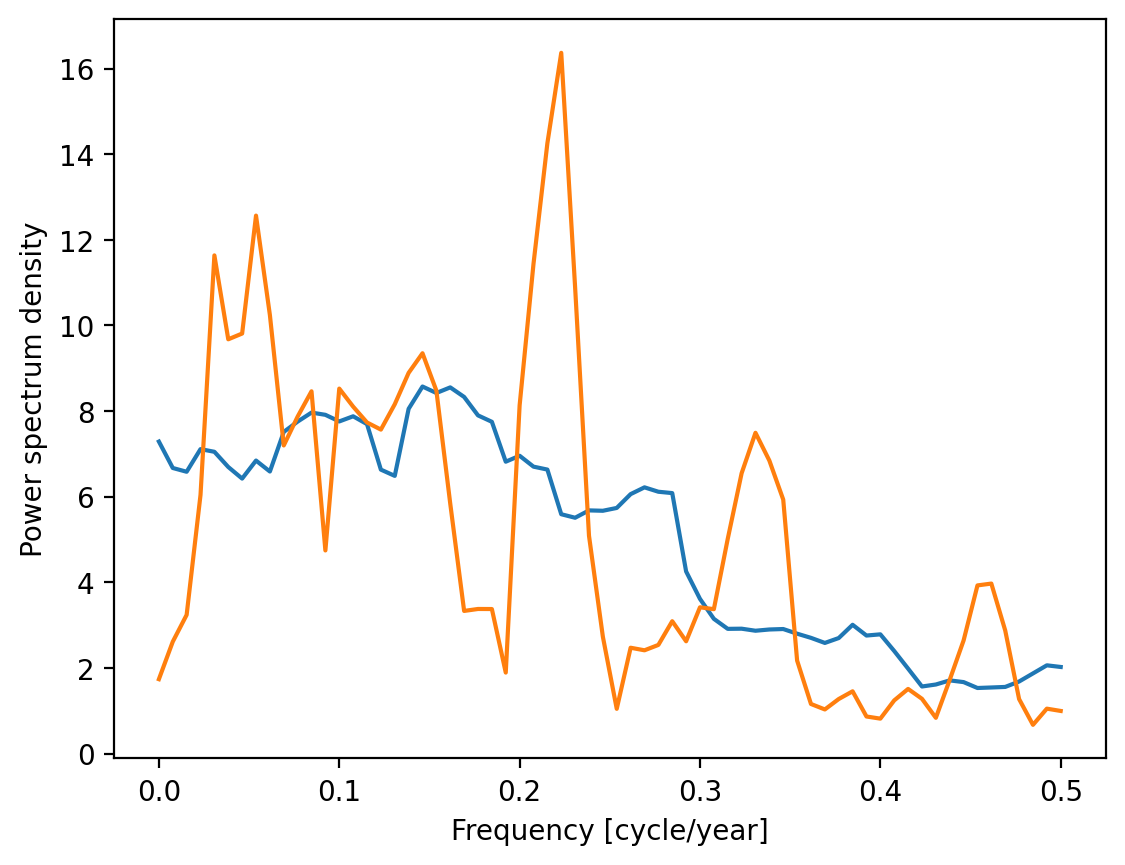

In [258]:
plt.plot(xf_mtm, yf_mtm, xf_mtm_r, yf_mtm_r)
plt.ylabel('Power spectrum density')
plt.xlabel('Frequency [cycle/year]')


In [259]:
reg_list, regression_formula = reg_list_formula('NearestPointAverage') #, 'NoRegressor', 'NearestPointAverage'
new_regression_formula = regression_formula.replace('sea_level','new_sea_level')

splain, sfitted, ssp_adj = adjust_psd(yf_full_mtm, residuals, reg_df, new_regression_formula, bootsize)


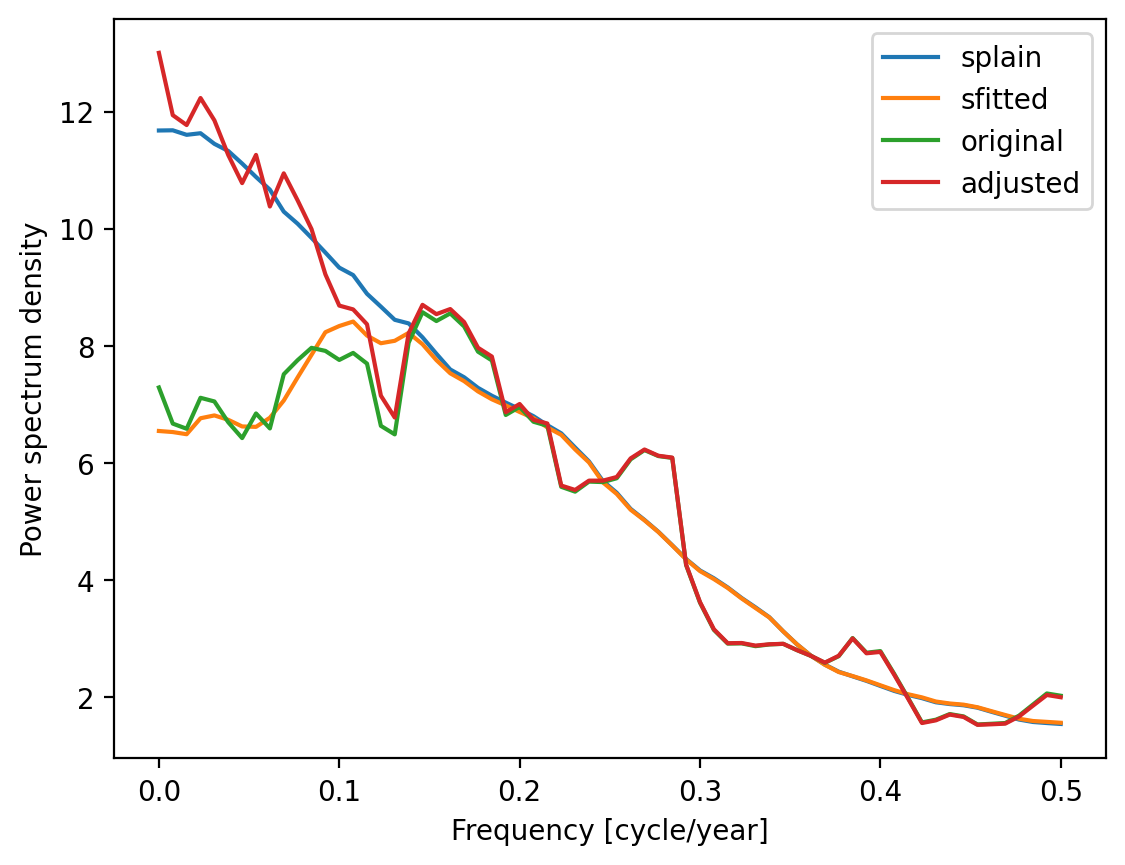

In [260]:
plt.plot(xf_mtm, splain[0:nt//2], label='splain')
plt.plot(xf_mtm, sfitted[0:nt//2], label='sfitted')
plt.plot(xf_mtm, yf_full_mtm[0:nt//2], label='original')
plt.plot(xf_mtm, ssp_adj[0:nt//2], label='adjusted')
plt.ylabel('Power spectrum density')
plt.xlabel('Frequency [cycle/year]')
plt.legend()

#plt.savefig('./figures/IncreasedNoise.pdf', dpi=150)

In [261]:
trend_df = bootstrap_trend(ssp_adj, residuals, reg_df, new_regression_formula, bootsize)

In [262]:
quant = [0.05, 0.17, 0.50, 0.83, 0.95]

rates, rates_q = rates_quantiles(trend_df, 2, quant)

for q in quant:
    rates_q[q] = res_na['rate_slr']+rates_q[q]

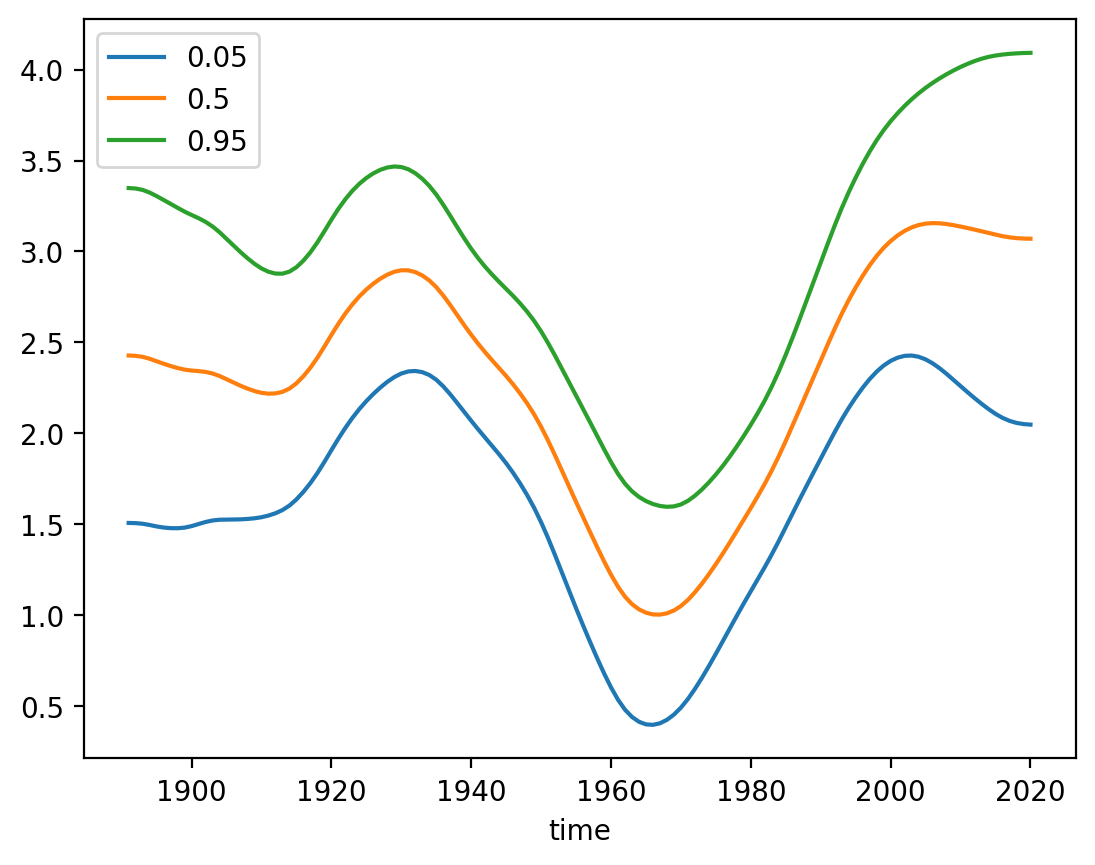

In [263]:
rates_q[[0.05,0.5,0.95]].plot()

#plt.savefig('./figures/rate_na_lag2.pdf', dpi=150)
plt.legend()

#### Check the convergence of adjust_psd

In [264]:
def adjust_psd2(sp, residuals, reg_df, regression_formula, bootsize):
    '''Adjust the power spectrum density of the residual by taking into account 
    the power reduction of fitting the model'''
    
    ssp_adj = sp
    
    for it in range(10):
        ssp = np.sqrt(ssp_adj) # Compute the amplitude spectrum from the power spectrum
        splain = np.zeros(nt)
        sfitted = np.zeros(nt)

        for i in range(bootsize):

            v = generate_residual(nt, ssp)

            # Replace residual in sea level data
            reg_df['new_sea_level'] = reg_df['sea_level'] - residuals + v

            # Estimate model
            res_gam = gam_model(reg_df, regression_formula, summary=False)

            residual1 = res_gam.resid_response.values

            splain = splain + loc.mtm(v, 1, NW=10, k=20)[2]
            sfitted = sfitted + loc.mtm(residual1, 1, NW=10, k=20)[2]

        splain = splain/bootsize
        sfitted = sfitted/bootsize
        ssp_adj = sp*(splain/sfitted)
        
        plt.plot(xf_mtm, splain[0:nt//2], label=f'iteration {it}')
        plt.legend()
    
    return splain, sfitted, ssp_adj

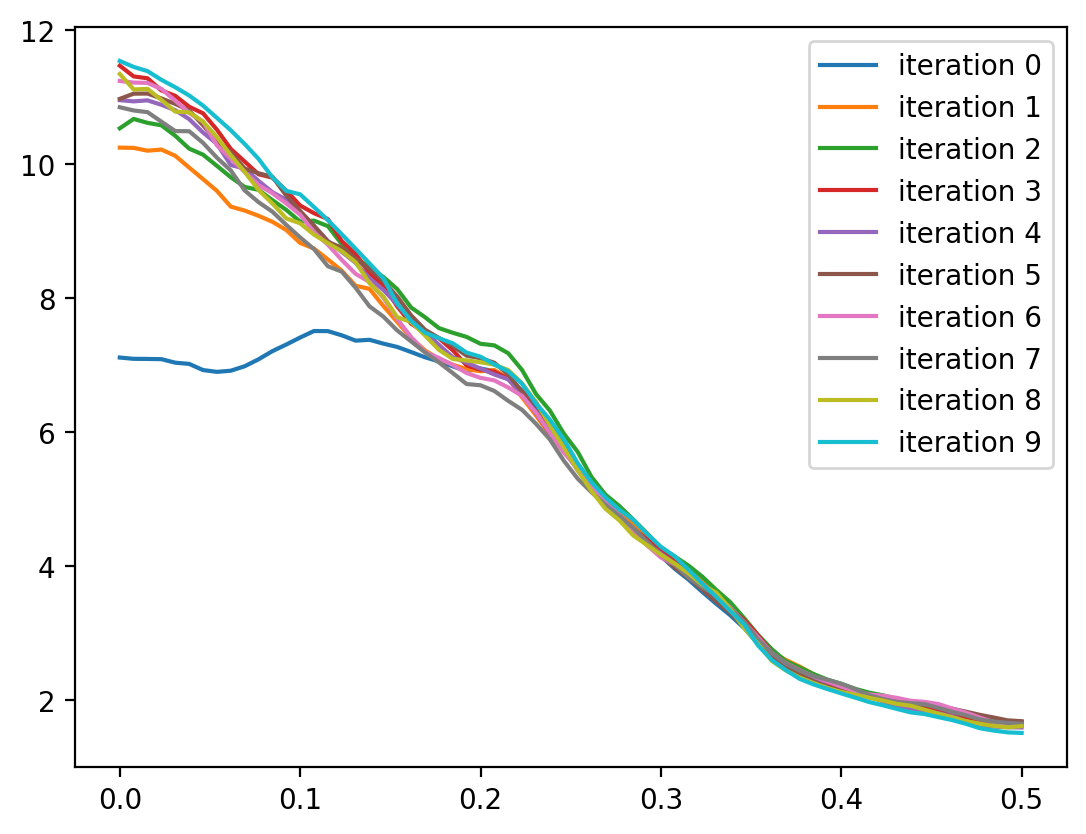

In [265]:
splain, sfitted, ssp_adj = adjust_psd2(yf_full_mtm, residuals, reg_df, new_regression_formula, bootsize)

Three iterations seem to be enough for convergence

#### Compute the rates for all methods

In [266]:
long_names = ['Trend only', 
              'Trend and nodal tide', 
              'Trend, nodal tide and wind (zonal velocity)', 
              'Trend, nodal tide and wind (zonal & meridional velocity)',
              'Trend, nodal tide and wind (pressure difference)',
              'Trend, nodal tide and wind (northern & southern pressure)']

short_names = ['Tr', 'TrNc', 'TrNcZw', 'TrNcW', 'TrNcPd', 'TrNcPns']

comb_names = [f'{short_names[i]} : {long_names[i]}' for i in range(6)]

In [ ]:
bootsize = 10000

trend_nr, rates_nr, rates_q_nr, spec_nr = rate_uncertainty('NoRegressor', reg_df, bootsize)
trend_nt, rates_nt, rates_q_nt, spec_nt = rate_uncertainty('NodalTide', reg_df, bootsize)
trend_na, rates_na, rates_q_na, spec_na = rate_uncertainty('NearestPointAverage', reg_df, bootsize)
trend_na_2, rates_na_2, rates_q_na_2, spec_na_2 = rate_uncertainty('NearestPointAverage2', reg_df, bootsize)
trend_pd, rates_pd, rates_q_pd, spec_pd = rate_uncertainty('PressureDifference', reg_df, bootsize)
trend_pd_2, rates_pd_2, rates_q_pd_2, spec_pd_2 = rate_uncertainty('PressureDifference2', reg_df, bootsize)

#### Store data as csv files

In [ ]:
for idx, df in enumerate([rates_nr, rates_nt, rates_na, rates_na_2, rates_pd, rates_pd_2]):
    df.to_csv(f'./outputs/{region}/{bootsize}/rates_{model_list[idx]}.csv')
    
for idx, df in enumerate([rates_q_nr, rates_q_nt, rates_q_na, rates_q_na_2, rates_q_pd, rates_q_pd_2]):
    df.to_csv(f'./outputs/{region}/{bootsize}/rates_quantiles_{model_list[idx]}.csv')

#### Compare standard error in trends and rates

In [ ]:
# Compute the standard errors in trends

set_nr = trend_nr.std(axis=1)
set_nt = trend_nt.std(axis=1)
set_na = trend_na.std(axis=1)
set_na_2 = trend_na_2.std(axis=1)
set_pd = trend_pd.std(axis=1)
set_pd_2 = trend_pd_2.std(axis=1)


In [ ]:
colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:purple', 'tab:blue', 'tab:purple', 'tab:cyan']

set_nr.plot(color = colors[0], label=short_names[0])
set_nt.plot(color = colors[1], label=short_names[1])
set_na.plot(color = colors[2], label=short_names[2])
set_na_2.plot(color = colors[3], label=short_names[3])
set_pd.plot(color = colors[4], label=short_names[4])
set_pd_2.plot(color = colors[5], label=short_names[5])

plt.ylabel('Trend standard error [cm]')
plt.legend()

In [ ]:
# Compute the standard errors in rates

ser_nr = rates_nr.std(axis=1)
ser_nt = rates_nt.std(axis=1)
ser_na = rates_na.std(axis=1)
ser_na_2 = rates_na_2.std(axis=1)
ser_pd = rates_pd.std(axis=1)
ser_pd_2 = rates_pd_2.std(axis=1)

In [ ]:
colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:purple', 'tab:blue', 'tab:cyan']

ser_nr.plot(color = colors[0], label=short_names[0])
ser_nt.plot(color = colors[1], label=short_names[1])
ser_na.plot(color = colors[2], label=short_names[2])
ser_na_2.plot(color = colors[3], label=short_names[3])
ser_pd.plot(color = colors[4], label=short_names[4])
ser_pd_2.plot(color = colors[5], label=short_names[5])

plt.ylabel('Rate standard error [mm/yr]')
plt.legend()



Obtain the time averages of the standard error

In [ ]:
print_text = 'Time mean of rate standard error:'
standard_errors = [ser_nr, ser_nt, ser_na, ser_na_2, ser_pd, ser_pd_2]

for idx, name in enumerate(short_names):
    print_text += f'\n{name}: {round(standard_errors[idx].mean(),2)} mm/yr'

print(print_text)


#### Compare power spectrum adjustment for the 6 methods

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(7,9))

spec_nr.plot(ax=ax[0,0], title=short_names[0])
spec_nt.plot(ax=ax[0,1], title=short_names[1], legend=False)
spec_na.plot(ax=ax[1,0], title=short_names[2], legend=False)
spec_na_2.plot(ax=ax[1,1], title=short_names[3], legend=False)
spec_pd.plot(ax=ax[2,0], title=short_names[4], legend=False)
spec_pd_2.plot(ax=ax[2,1], title=short_names[5], legend=False)

ax[2,0].set_xlabel('Frequency [1/year]')
ax[2,1].set_xlabel('Frequency [1/year]')

ax[0,0].set_ylabel('Power spectrum')
ax[1,0].set_ylabel('Power spectrum')

for idx in range(6):
    ax.flat[idx].set_ylim([0, 18])
    ax.flat[idx].grid(True)

fig.tight_layout()

#### Export model performance data

In [ ]:
res_ar = np.zeros([6, 2])

for idd, df in enumerate([res_full_nr, res_full_nt, res_full_na, res_full_na_2, res_full_pd, res_full_pd_2]):

    res_ar[idd, 0] = round(df.df_model,1)
    res_ar[idd, 1] = round(df.deviance,0)
        
resm_df = pd.DataFrame(res_ar, 
                      index=comb_names, 
                      columns=['Degrees of freedom', 'Deviance'])

resm_df.index.name = 'Statistical model'

In [ ]:
resm_df.to_csv(f'./outputs/{region}/{bootsize}/table_model_performance.csv')

In [ ]:
long_names = ['Trend only', 
              'Trend and nodal tide', 
              'Trend, nodal tide and wind (zonal velocity)', 
              'Trend, nodal tide and wind (zonal&meridional velocity)', 
              'Trend, nodal tide and wind (pressure difference)', 
              'Trend, nodal tide and wind (northern&southern pressure)']

short_names = ['Tr', 'TrNc', 'TrNcZw', 'TrNcW', 'TrNcPd', 'TrNcNSP']

comb_names = [f'{short_names[i]} : {long_names[i]}' for i in range(6)]


res_ar = np.zeros([6, 2])

for idd, df in enumerate([res_full_nr, res_full_nt, res_full_na, res_full_na_2, res_full_pd, res_full_pd_2]):

    res_ar[idd, 0] = round(df.df_model,1)
    res_ar[idd, 1] = round(df.deviance,0)
        
resm_df = pd.DataFrame(res_ar, 
                      index=comb_names, 
                      columns=['Degrees of freedom', 'Deviance'])

resm_df.index.name = 'Statistical model'

In [ ]:
resm_df

In [ ]:
rates_q_nr[0.50]

In [ ]:
t1 = 2000
all_t0 = [1900, 1920, 1940]

list_rates = [rates_nr, rates_nt, rates_na, rates_na_2, rates_pd, rates_pd_2]
list_rates_q = [rates_q_nr, rates_q_nt, rates_q_na, rates_q_na_2, rates_q_pd, rates_q_pd_2]

col_names = [f'$r_{{{t1}-{t1+19}}}$ vs $r_{{{y}-{y+19}}}$' for y in all_t0]

res_ar = np.zeros([6, 3])

for idt, t0 in enumerate(all_t0):
    for idd, (rates, rates_q) in enumerate(zip(list_rates, list_rates_q)):
        sigma = np.std(rates.loc[t1: t1+19].mean(axis=0) - 
                       rates.loc[t0: t0+19].mean(axis=0))

        # observed difference in rate
        drate = (rates_q[0.50].loc[t1: t1+19].mean(axis=0) - 
                 rates_q[0.50].loc[t0: t0+19].mean(axis=0))

        # p-value is the probability that the estimated rate difference would exceed  
        # the value drate if the true rates were equal
        res_ar[idd, idt] = round(1-norm.cdf(drate/sigma), 2)
    
res_df = pd.DataFrame(res_ar, 
                      index=short_names, 
                      columns=col_names)

res_df.index.name = 'Statistical model'

In [ ]:
res_df

### Conclusions on wind models
The TrNcW model performs better than TrNcZw and TrNcPd performs better than TrNcPns (lower standard error) 

## Extend wind time series back in time

In [ ]:
wind_rec = pd.DataFrame({'NearestPointAverage2' : 
                         res_full_na_2.params.u2_mean*nearest_point_df.u2_mean + res_full_na_2.params.v2_mean*nearest_point_df.v2_mean})
wind_rec['PressureDifference'] = (res_full_pd.params.pressure_diff * 
                                  dang_df.pressure_diff)

window = 21
lowess = sm.nonparametric.lowess
frac = window/wind_rec.shape[0]

for wind_method in wind_rec.columns:
    p = Polynomial.fit(wind_rec.index, wind_rec[wind_method], 3)
    
    wind_rec[f'{wind_method}_trend'] = p(wind_rec.index)
    
    wind_rec[f'{wind_method}_dt'] = (wind_rec[wind_method] 
                                     - wind_rec[f'{wind_method}_trend'])
    
    wind_rec[f'{wind_method}_lowess'] = lowess(wind_rec[f'{wind_method}_dt'], 
                                               wind_rec.index, frac, 
                                               return_sorted=False)


In [ ]:
wind_rec

In [ ]:
# Export data
wind_rec.to_csv(f'./outputs/{region}/WindInfluence.csv')

In [ ]:
wind_rec[['NearestPointAverage2_lowess', 'PressureDifference_lowess']].plot()

## Check the units of wind spectra

From Parseval's theorem it follows that the variance (average power) of a process is equal to integrating the power spectrum over all frequency.

$P = Var ⁡ ( x ) = \int_{-\infty}^{\infty}{S_{xx}(f)\,df} $



In [ ]:
xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['NearestPointAverage2_dt'].values, 1)

print('Variance of signal [cm**2]')
print(np.var(wind_rec['NearestPointAverage2_dt']))

print('Sum of the spectral coefficients:')
N = 0.5 # Niquist frequency
df = N/len(yf_mtm)

# Factor 2 because we kept only half of the spectrum since the spectra of real 
#signals it is symmetric.
print(2*np.sum(yf_mtm)*df)

## Nodal tide

Check nodal tide time series, phase lag and amplitude resulting from the linear regression and compare to the equilibrium tide. Also, define a GAM model including wind (velocity) but that's corrected for the equilibrium tide. Compare the multitaper spectrum of the residuals of this GAM to those of the TrNcZw GAM.

In [ ]:
def nodal_tides_potential(lat, time_years):
    """
    Function to obtain the nodal cycle
    
    """
    h2 = 0.6032
    k2 = 0.298

    #nodal cycle correction
    A = 0.44*(1+k2-h2)*20*(3*np.sin(lat*np.pi/180.)**2-1)/10  # mm to cm
    nodcyc = A*np.cos((2*np.pi*(time_years-1922.7))/18.61 + np.pi)
    
    return nodcyc


def station_coords(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = f'{data_tidegauges_dir}/tide gauges/rlr_annual/filelist.txt'
    loc_num = [20, 22, 23, 24, 25, 32]
    col_names = ['id', 'lat', 'lon', 'station', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df

In [ ]:
nodal_df = pd.DataFrame({'TrNc' : res_full_nt.params.nod1*reg_df['nod1'] + res_full_nt.params.nod2*reg_df['nod2'],
                        'TrNcW' : res_full_na_2.params.nod1*reg_df['nod1'] + res_full_na_2.params.nod2*reg_df['nod2'],
                        'TrNcPd' : res_full_pd.params.nod1*reg_df['nod1'] + res_full_pd.params.nod2*reg_df['nod2']})


station_coords_df = station_coords()

nodal_eq_df = pd.DataFrame({'time': nodal_df.index}).set_index('time')

for idx in station_coords_df.index:
    nodal_eq_df[station_coords_df['station'][idx]] = nodal_tides_potential(station_coords_df['lat'][idx], nodal_df.index)
    
nodal_df['Equilibrium tide'] = nodal_eq_df.mean(axis=1)

In [ ]:
nodal_df.to_csv(f'./outputs/{region}/NodalTide.csv')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

colors = ['tab:red', 'tab:orange', 'tab:blue', 'grey']

for idx, data in enumerate(nodal_df):
    
    nodal_df[data].plot(label=data, color=colors[idx])


ax.set_xlabel('Time [years]')
ax.set_ylabel('Nodal tide [cm]')
ax.grid(True)
ax.legend(loc='lower right')


The amplitude of the different nodal tides:

In [ ]:
A_nt = nodal_df['TrNc'].max()
A_w = nodal_df['TrNcW'].max()
A_pd = nodal_df['TrNcPd'].max()
A_eq = nodal_df['Equilibrium tide'].max()

In [ ]:
print(f'Amplitudes:\nTrNc: {A_nt} cm\nTrNcW: {A_w} cm\nTrNcPd: {A_pd} cm\nEquilibrium tide: {A_eq} cm')

The phase lag:

In [ ]:
Ph_nt = nodal_df['TrNc'].iloc[:25].idxmax()
Ph_w = nodal_df['TrNcW'].iloc[:25].idxmax()
Ph_pd = nodal_df['TrNcPd'].iloc[:25].idxmax()
Ph_eq = nodal_df['Equilibrium tide'].iloc[:25].idxmax()

In [ ]:
print(f'Years maxima:\nTrNc: {Ph_nt}\nTrNcW: {Ph_w}\nTrNcPd: {Ph_pd}\nEquilibrium tide: {Ph_eq}')

In [ ]:
print(f'Phase lag:\nTrNc: {Ph_eq - Ph_nt} years\nTrNcW: {Ph_eq - Ph_w} years\nTrNcPd: {Ph_eq - Ph_pd} years')

### Compare spectra of residuals

In [ ]:
reg_df['sea_level_corrected'] = reg_df['sea_level'] - nodal_df['Equilibrium tide']

In [ ]:
# Nearest point average, including only zonal wind

reg_list_na_eq = ['u2_mean']

regression_formula_na_eq = 'sea_level_corrected ~ '+' + '.join(reg_list_na_eq)
    
regression_formula_na_eq

In [ ]:
def reg_list_formula(model):
    if model == 'NoRegressor':
        reg_list = reg_list_nr
        regression_formula = regression_formula_nr
    elif model == 'NodalTide':
        reg_list = reg_list_nt
        regression_formula = regression_formula_nt  
    elif model == 'NearestPointAverage':
        reg_list = reg_list_na
        regression_formula = regression_formula_na
    elif model == 'PressureDifference':
        reg_list = reg_list_pd
        regression_formula = regression_formula_pd
    elif model == 'NearestPointAverage2':
        reg_list = reg_list_na_2
        regression_formula = regression_formula_na_2
    elif model == 'PressureDifference2':
        reg_list = reg_list_pd_2
        regression_formula = regression_formula_pd_2
    elif model == 'EquilibriumTide':
        reg_list = reg_list_na_eq
        regression_formula = regression_formula_na_eq
        
    return reg_list, regression_formula

In [ ]:
res_na_eq, res_full_na_eq = compute_model('EquilibriumTide', reg_df)

#### Calculate residuals

In [ ]:
residuals_df = pd.DataFrame({'time':res_na_2.index.values}).set_index('time')
residuals_df['NearestPointAverage2'] = reg_df['sea_level'] - res_na_2['total']
residuals_df['EquilibriumTide'] = reg_df['sea_level'] - res_na_eq['total']

In [ ]:
residuals_df.plot()

#### Obtain and plot spectra

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

# Detrend the time series of residuals
p = Polynomial.fit(residuals_df.index, residuals_df['NearestPointAverage2'], 3)
residuals_df['NearestPointAverage2_dt'] = residuals_df['NearestPointAverage2'] - p(residuals_df.index)

p = Polynomial.fit(residuals_df.index, residuals_df['EquilibriumTide'], 3)
residuals_df['EquilibriumTide_dt'] = residuals_df['EquilibriumTide'] - p(residuals_df.index)

xf_mtm, yf_mtm, _ = loc.mtm(residuals_df['NearestPointAverage2_dt'].values, 1)

# Change x-axis from frequency to period
xf_p = 1/xf_mtm
ax.plot(xf_p[2:], yf_mtm[2:], label='TrNcW', color=colors[1])


xf_mtm, yf_mtm, _ = loc.mtm(residuals_df['EquilibriumTide_dt'].values, 1)
ax.plot(xf_p[2:], yf_mtm[2:], label='Equilibrium tide', color=colors[3])


#l1, = ax[1,0].plot([],[], c='grey', label='unfiltered annual data')
#l2, = ax[1,0].plot([],[], c='grey', ls='--', label='LOWESS-filtered')
ax.legend()

ax.set_title('Multitaper spectra')
ax.set_ylabel('Power density'+r'$[cm^2.year]$')
ax.set_xlabel('Period [year]')

ax.grid()

In [ ]:
residuals_df.to_csv(f'./outputs/{region}/NodalTideResiduals.csv')